### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
# sc.stop()
sc = SparkContext(master="local[4]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BBBBSSBB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12884
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    106.7| 43.4622| -76.4933|       TMAX|USC00306314|     0|[20 50 40 4C 80 4...|1926.0|BBBBSSBB|
|    106.7| 43.4622| -76.4933|       TMAX|USC00306314|     0|[00 00 A0 D3 00 0...|1927.0|BBBBSSBB|
|    106.7| 43.4622| -76.4933|       TMAX|USC00306314|     1|[80 4D 80 D4 E0 D...|1928.0|BBBBSSBB|
|    106.7| 43.4622| -76.4933|       TMAX|USC00306314|     1|[00 53 00 00 00 C...|1929.0|BBBBSSBB|
|    106.7| 43.4622| -76.4933|       TMAX|USC00306314|     2|[E0 54 E0 55 00 4...|1930.0|BBBBSSBB|
+---------+--------+---------+-----------+-----------+------+-------------

### Select data for a particular station and measurement type

In [2]:
sqlContext.registerDataFrameAsTable(df, 'weather')
Query = "SELECT station FROM weather GROUP BY station"
df1 = sqlContext.sql(Query)
df1.show(139)

+-----------+
|    station|
+-----------+
|US1NYOS0001|
|USC00302239|
|US1NYOD0014|
|USC00301771|
|USC00307549|
|USC00305769|
|USC00308104|
|USC00303889|
|USC00303284|
|USC00304102|
|USC00305711|
|USC00306314|
|USW00014772|
|USC00308578|
|USC00308080|
|US1NYCY0010|
|USC00300015|
|CA006150816|
|USC00305580|
|USC00302047|
|USC00307842|
|USC00301541|
|USR0000NSCH|
|USC00306184|
|USC00300668|
|USC00303452|
|USC00304944|
|USC00301138|
|USC00303289|
|USC00306028|
|USC00301728|
|USC00304957|
|USC00305489|
|USC00305714|
|USC00307405|
|USC00302917|
|US1NYOD0007|
|USC00309389|
|US1NYMD0008|
|USC00300780|
|USC00309480|
|USC00304537|
|USC00303281|
|USC00307544|
|USC00300828|
|USW00014717|
|US1NYHR0009|
|US1NYOD0002|
|USC00300018|
|USW00054773|
|USC00302720|
|USC00303851|
|USC00307748|
|US1NYOG0026|
|USW00094794|
|USC00307413|
|USC00308733|
|USC00303125|
|USW00014774|
|USC00309544|
|USC00301765|
|USC00306375|
|USC00303322|
|CA006150815|
|USC00301713|
|US1NYWR0003|
|USC00305199|
|USW00014771|
|US1NY

In [3]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00306314')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
# T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00306314'
86 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    106.7| 43.4622| -76.4933|       PRCP|USC00306314|     0|[00 00 00 45 00 0...|1926.0|BBBBSSBB|
|    106.7| 43.4622| -76.4933|       PRCP|USC00306314|     0|[00 49 00 00 00 0...|1927.0|BBBBSSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(86, 365)

### Script for plotting yearly plots

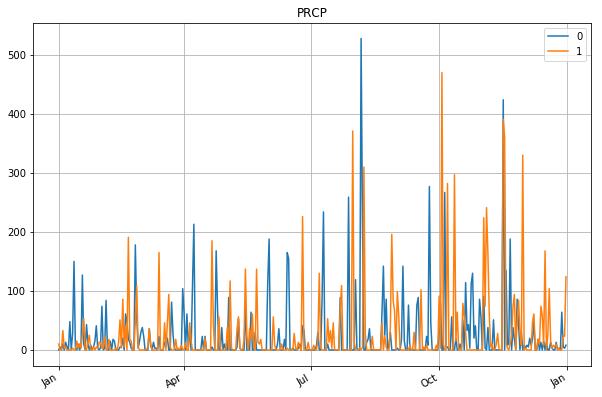

In [4]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
# title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [5]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/Users/lingranxia/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


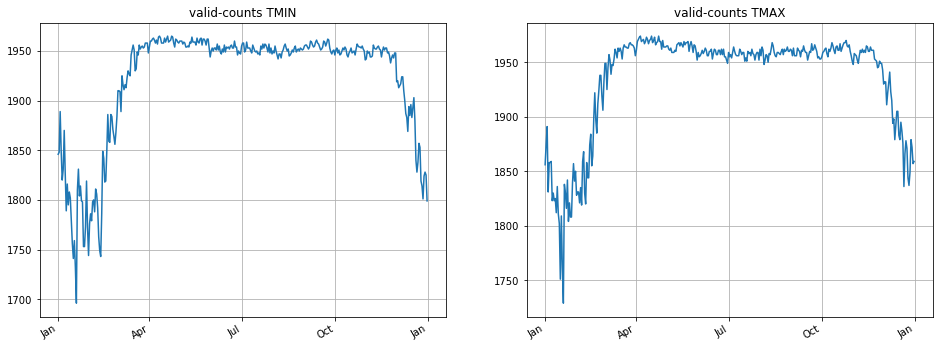

In [6]:
plot_pair(['TMIN','TMAX'],plot_valid)

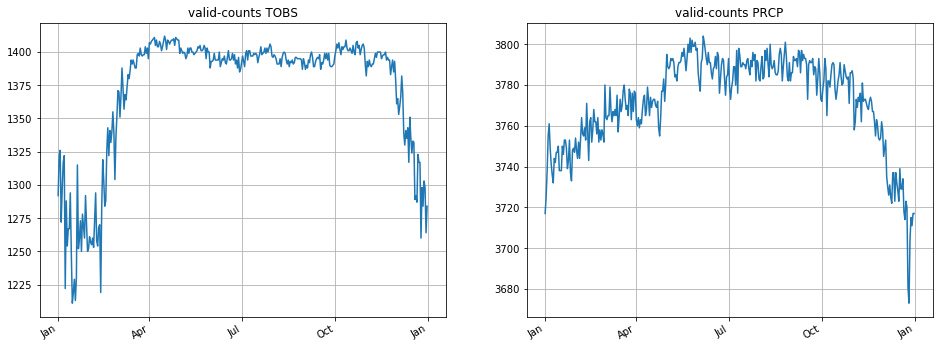

In [7]:
plot_pair(['TOBS','PRCP'],plot_valid)

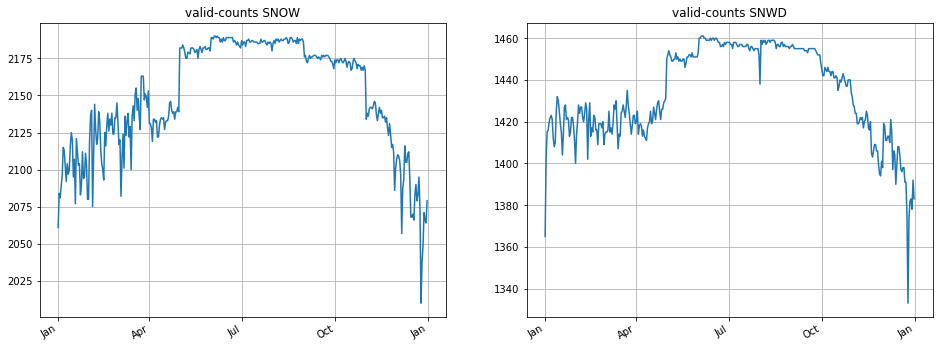

In [8]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [9]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']/10
    std=np.sqrt(STAT[m]['Var'])/10
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

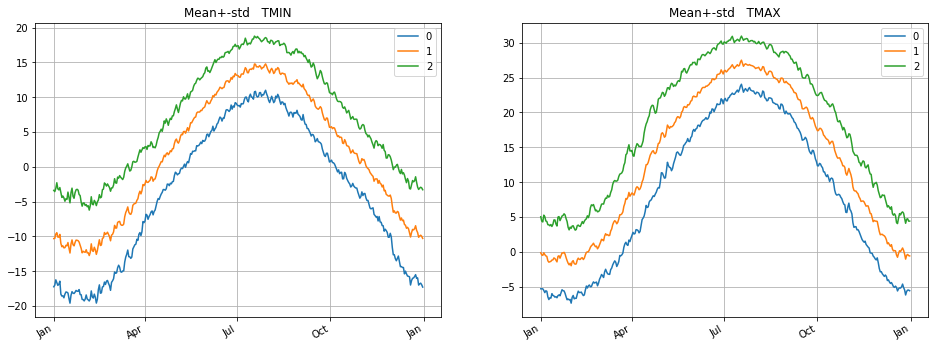

In [10]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

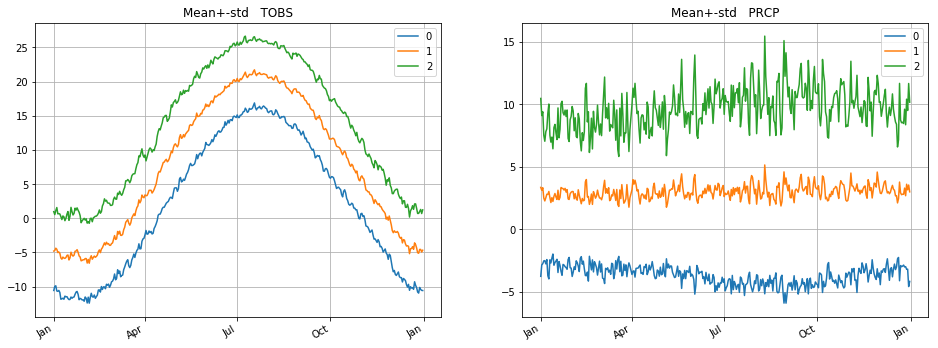

In [11]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

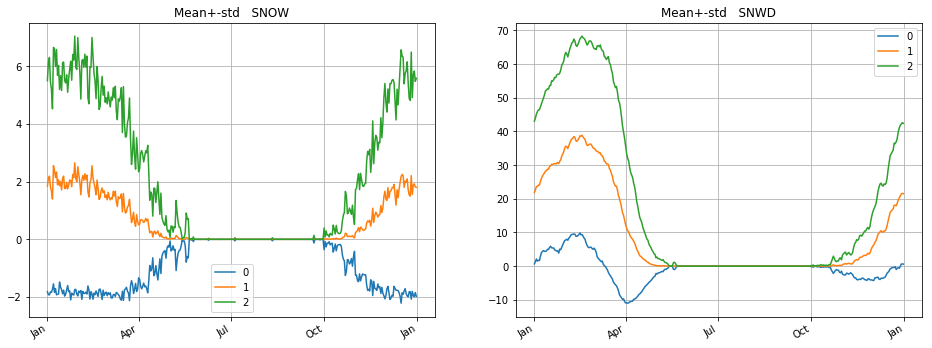

In [12]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [13]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

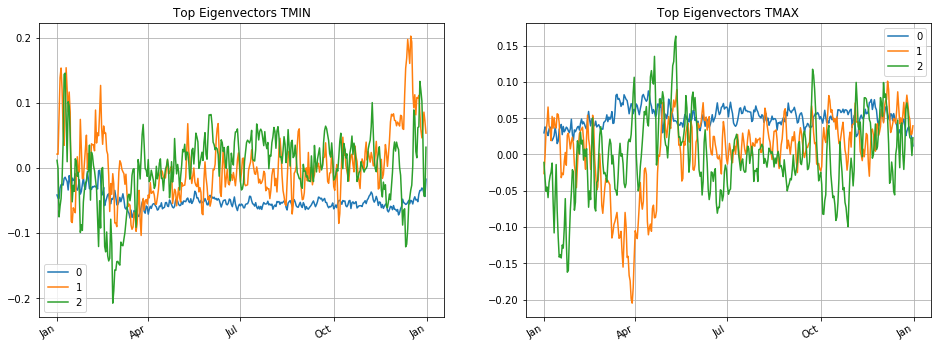

In [14]:
plot_pair(['TMIN','TMAX'],plot_eigen)

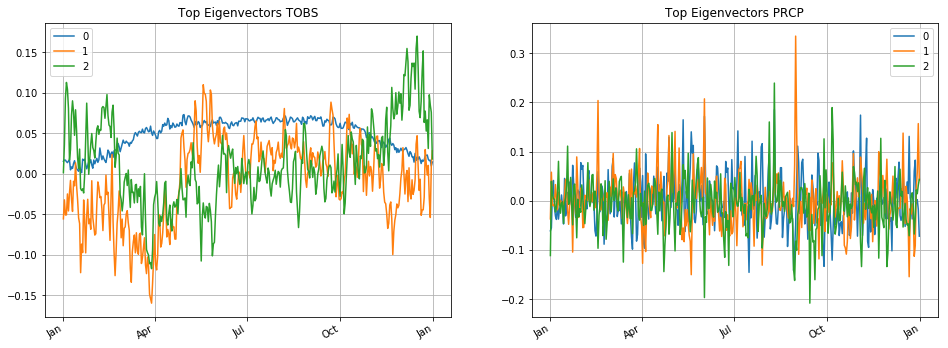

In [15]:
plot_pair(['TOBS','PRCP'],plot_eigen)

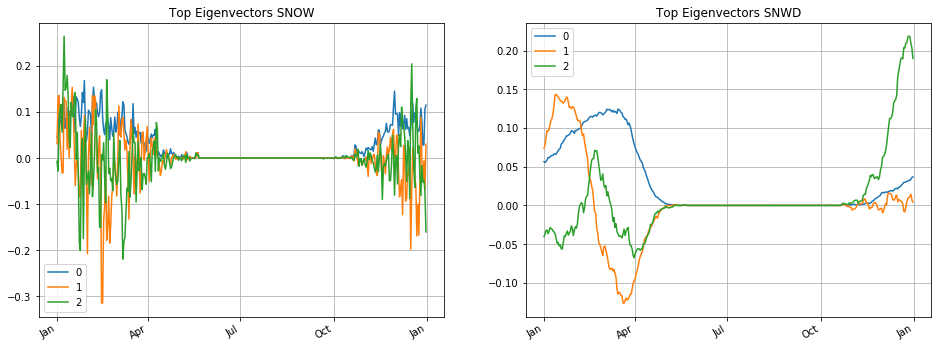

In [16]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [17]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

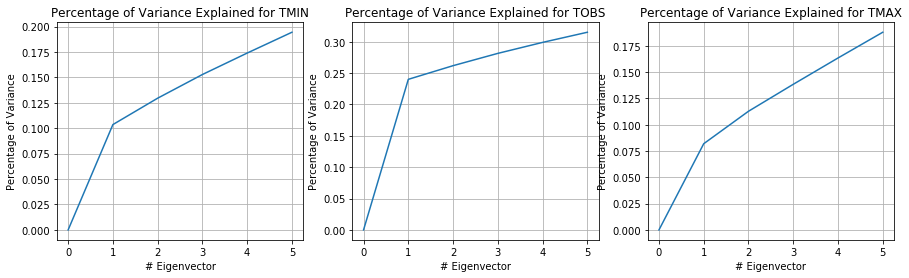

In [18]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

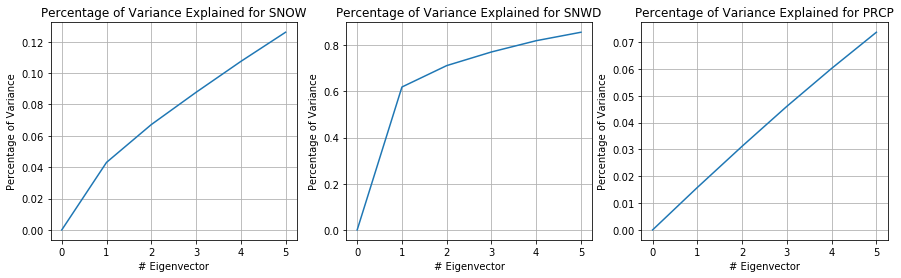

In [19]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [20]:
sc.stop()